# Discrete LQR

**Goal:** select control inputs to minimize
\begin{eqnarray}
J&=&\frac{1}{2}\mathbf{x}_N^TR_{xx_N} \mathbf{x}_N +
\frac{1}{2}\sum_{k=0}^{N-1}[\mathbf{x}_k^TR_{xx_k}\mathbf{x}_k+\mathbf{u}^T_kR_{uu_k}\mathbf{u}_k] \\
\text{Dynamics:} \quad 
\mathbf{x}_{k+1}&=&A_k\mathbf{ x}_k + B_k \mathbf{ u}_k
\end{eqnarray}

* Assume that $R_{xx_N}=R_{xx_N}^T \geq 0$, $R_{xx}=R_{xx}^T \geq 0$, and $R_{uu}=R_{uu}^T > 0 $

As on 16-17, for LQR we itialize with $P_N=R_{xx_N}$ and then solve backwards from $N-1$ to $0$ using the following iteration:
\begin{eqnarray}
(i) F_k&=&\left[R_{uu_k}+B_{k}^TP_{k+1}B_{k}\right]^{-1} B_{k}^T
P_{k+1} A_{k} \\ (ii)
P_k &=& R_{xx_k} +
	A_{k}^T\left\{ P_{k+1} - P_{k+1} B_{k}
	\left[R_{k}+B_{k}^TP_{k+1}B_{k}\right]^{-1} B_k^T P_{k+1} \right\}
	A_{k}
\end{eqnarray}
This yields a time-varying control since $F$ changes with $k$. 

* Typically we implement a time-invariant controller $u[k]=-Fx[k]$, where $F$ is found using the equation above with $P_{k+1}$ replaced with the solution of 
$$ 
P_{ss} = R_{xx} + A^T\left\{ P_{ss} - P_{ss} B
\left[R_{uu}+B^TP_{ss}B\right]^{-1} B^T P_{ss} \right\} A  
$$

* If the system $[A,B,C]$ (where $R_{xx}=C^TC$) is stabilizable and observable, then the iteration for $P_k$ converges to the unique solution for $P_{ss} > 0$

* This notebook explores the role of $R_{xx_N}$ in the $P_k$ and the differences in state response in using $F$ and $F_k$ in the feeback control.

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

import random, sys
import scipy.linalg
from scipy import linalg as la

from sympy import Matrix, init_printing
init_printing()

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 
from IPython.display import display

from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

Running Python: 3.8.16


In [2]:
# Discretize A and Bu
def Discretize(A,Bu,dt = 1):
    Nx,Nu = Bu.shape
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]
    Ad = CC[0:Nx,0:Nx]
    return Ad, Bd 

## 2x2 Example

In [3]:
# cts dynamics of pendulum
Ts = 0.25
Ac = np.array([[0, 1], [-1, -0.01]]) # dynamics (cts)
Bc = np.array([[0], [1]])           # actuator input

A, B = Discretize(Ac,Bc,Ts)
n,_ = A.shape                      # state dim
N = 20                               # LQR time steps
RxxN = np.array([[1, 0], [0, 2]])     # terminal state cost 
P = np.zeros((n,n,N+1))              # cost to go matrix
Rxx = np.array([[1, 0], [0, 0.1]])     # state cost in LQR
Ruu = np.array([1])                   # control cost in LQR
K = np.arange(N+1)                   # time horizon   

# backward recursion for P and F
F = np.zeros((1,n,N))              # gains
P[:,:,N] = RxxN                         # P initialization
for k in np.arange(N-1,-1,-1):
    P[:,:,k] = Rxx+A.T@(P[:,:,k+1]-P[:,:,k+1]@B@np.linalg.inv(Ruu+B.T@P[:,:,k+1]@B)@B.T@P[:,:,k+1])@A
    F[:,:,k] = np.linalg.inv(np.atleast_2d(Ruu+B.T@P[:,:,k+1]@B))@B.T@P[:,:,k+1]@A  

P steady state value


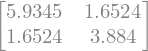


Compare to P Numerical


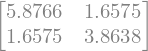


Computed Steady State Gain



Compare to Numerical Gain


In [4]:
# Steady State Solution
P_ss = la.solve_discrete_are(A, B, Rxx, Ruu) # There are 2 ARE of interest, make sure you are using the right one
print('P steady state value')
display(Matrix(np.round(P_ss,4)))
print('\nCompare to P Numerical')
display(Matrix(np.round(P[:,:,0],4)))

F_ss = np.linalg.inv(np.atleast_2d(Ruu+B.T@P_ss@B))@B.T@P_ss@A
print('\nComputed Steady State Gain')
display(Matrix(np.round(F_ss,4)))
print('\nCompare to Numerical Gain')
display(Matrix(np.round(F[:,:,0],4)))

## Cost to Go $P$

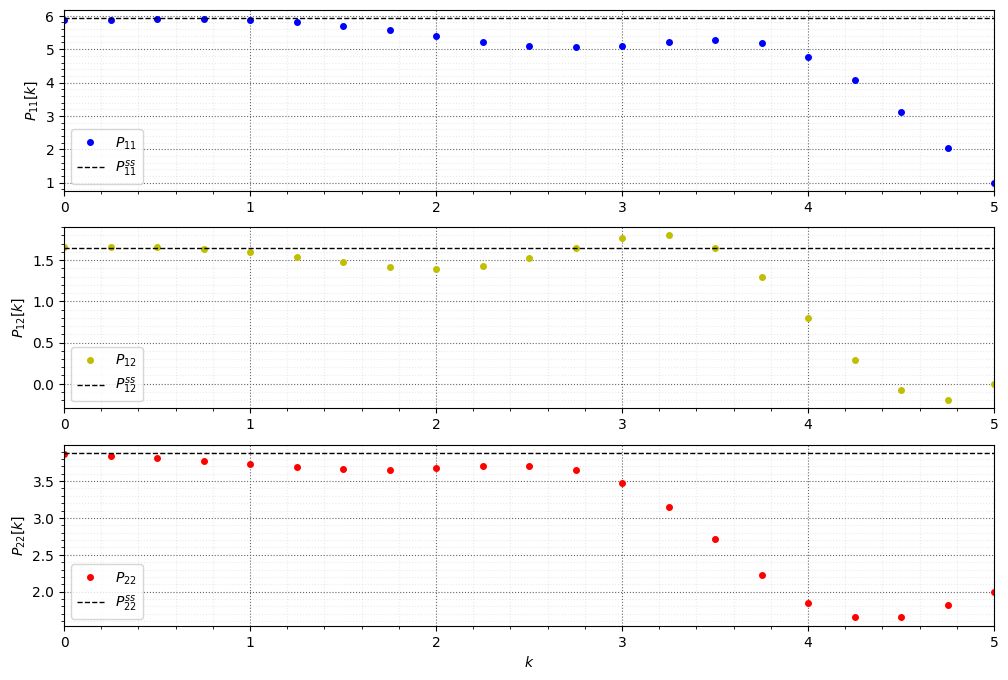

In [5]:
plt.figure(1,figsize=(12,8))
ax1 = plt.subplot(3, 1, 1)
ax1.plot(K*Ts,P[0,0,:],'bo',ms=4,label=r'$P_{11}$')
ax1.plot([0,N*Ts],[P_ss[0,0],P_ss[0,0]],'k--',lw=1,label=r'$P^{ss}_{11}$')
plt.xlim([0,N*Ts])
plt.ylabel(r'$P_{11}[k]$')
nicegrid()
plt.legend(loc='best')
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(K*Ts,P[0,1,:],'yo',ms=4,label=r'$P_{12}$')
ax2.plot([0,N*Ts],[P_ss[0,1],P_ss[0,1]],'k--',lw=1,label=r'$P^{ss}_{12}$')
plt.ylabel(r'$P_{12}[k]$')
nicegrid()
plt.legend(loc='best')
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(K*Ts,P[1,1,:],'ro',ms=4,label=r'$P_{22}$')
ax3.plot([0,N*Ts],[P_ss[1,1],P_ss[1,1]],'k--',lw=1,label=r'$P^{ss}_{22}$')
plt.ylabel(r'$P_{22}[k]$')
plt.xlabel(r'$k$')
nicegrid()
plt.legend(loc='best')
plt.tight_layout
plt.savefig("figs/DLQR_ex2_1.png")
plt.show()

The plots show that, if $N$ is large then $P_k$ can easily converge to $P_{ss}$ 

## Control Gains $F$

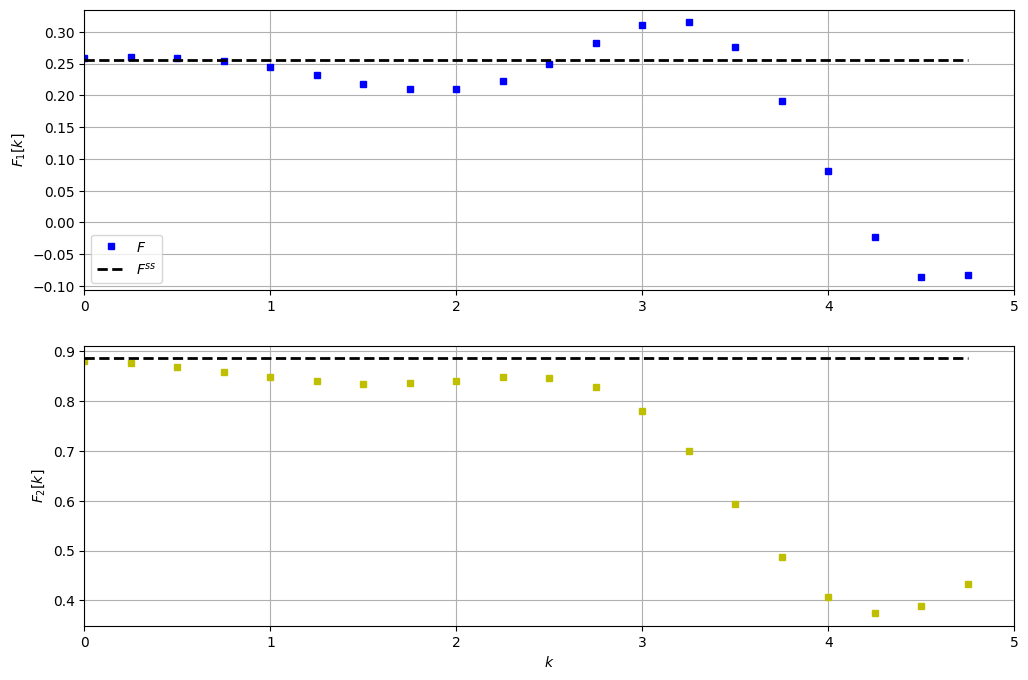

In [6]:
plt.figure(2,figsize=(12,8))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(K[:-1]*Ts,F[0,0,:],'bs',ms=4,label=r'$F$')
ax1.plot([0,(N-1)*Ts],[F_ss[0,0],F_ss[0,0]],'k--',lw=2,label=r'$F^{ss}$')
plt.xlim([0,N*Ts])
plt.ylabel(r'$F_1[k]$')
plt.grid(True)
plt.legend(loc='best')
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(K[:-1]*Ts,F[0,1,:],'ys',ms=4,label=r'$F$')
ax2.plot([0,(N-1)*Ts],[F_ss[0,1],F_ss[0,1]],'k--',lw=2,label=r'$F^{ss}$')
plt.ylabel(r'$F_2[k]$')
plt.grid(True)
plt.xlabel(r'$k$')
plt.savefig("figs/DLQR_ex2_2.png")
plt.show()

The time-varying gains $F_k$ and steady state gains $F$ are similar for small $k$, which will be the stat of the state simulation. Thus would expect the state response to be similar for both. The gains for larger $k$ will depend heavily on $R_{xx_N}$ -- is the terminal state penalized more/less heavily? 

In [7]:
# state response
x0 = np.array([2, 2])    # state initial condition
X = np.zeros((n,1,N+1))
X_ss = np.zeros((n,1,N+1))
U = np.zeros((n,1,N+1))
U_ss = np.zeros((n,1,N+1))
X[:,0,0] = x0
X_ss[:,0,0] = x0

Acl_ss = A - B@F_ss

for k in np.arange(1,N+1):
        X[:,0,k] = (A - B@F[:,:,k-1])@X[:,0,k-1]
        X_ss[:,0,k] = Acl_ss@X_ss[:,0,k-1]
        U[:,0,k-1] = F[:,:,k-1]@X[:,0,k-1]
        U_ss[:,0,k-1] = F_ss@X_ss[:,0,k-1]

## State response
Compare state response using optimal and suboptimal (steady state $F$) gains.

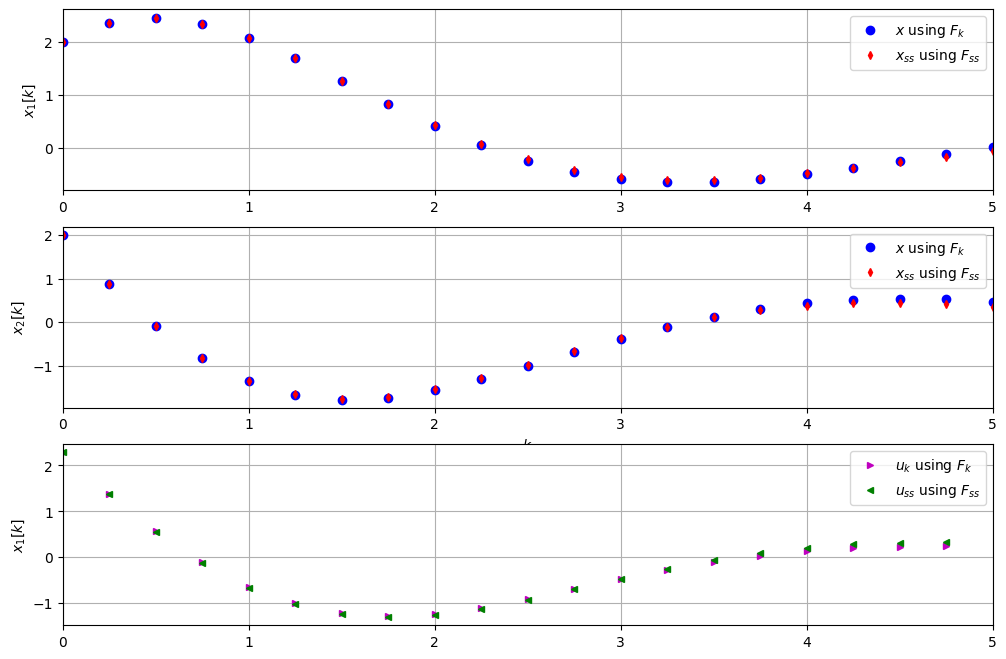

In [8]:
plt.figure(3,figsize=(12,8))
ax1 = plt.subplot(3, 1, 1)
ax1.plot(K*Ts,X[0,0,:],'bo',ms=6,label=r'$x$ using $F_k$')
ax1.plot(K*Ts,X_ss[0,0,:],'rd',ms=4,label=r'$x_{ss}$ using $F_{ss}$')
plt.xlim([0,N*Ts])
plt.ylabel(r'$x_1[k]$')
plt.grid(True)
plt.legend(loc='best')
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(K*Ts,X[1,0,:],'bo',ms=6,label=r'$x$ using $F_k$')
ax2.plot(K*Ts,X_ss[1,0,:],'rd',ms=4,label=r'$x_{ss}$ using $F_{ss}$')
#plt.ylim([-1,4])
plt.xlim([0,N*Ts])
plt.ylabel(r'$x_2[k]$')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel(r'$k$')
ax3 = plt.subplot(3, 1, 3)
ax3.plot(K[:-1]*Ts,U[0,0,:-1],'m>',ms=4,label=r'$u_k$ using $F_{k}$')
ax3.plot(K[:-1]*Ts,U_ss[0,0,:-1],'g<',ms=4,label=r'$u_{ss}$ using $F_{ss}$')
plt.xlim([0,N*Ts])
plt.ylabel(r'$x_1[k]$')
plt.grid(True)
plt.legend(loc='best')
plt.savefig("figs/DLQR_ex2_3.png")
plt.show()

See large differences in the cost to go matrices $P[k]$ and $P_{ss}$, but the state response of $u[k]=-F_{ss}x[k]$ is still very similar to that from $u[k]=-F_{k}x[k]$ 
* Typiucally see that the state has already convereged close to 0 before the differences in the control gains are evident

## Comparison of effect of $N$ and $R_{xx_N}$

In [9]:
# Try perturbing the final cost to see impact on the state response

def f(logbeta = 0, N = 20):
    Fp = np.zeros((1,n,N))
    Pp = np.zeros((n,n,N+1))
    Fp1 = np.zeros((1,n,N))
    Pp1 = np.zeros((n,n,N+1))
    Pp[:,:,N] = RxxN
    Pp1[:,:,N] = (10**logbeta)*RxxN
    for k in np.arange(N-1,-1,-1):
        Pp[:,:,k] = Rxx+A.T@(Pp[:,:,k+1]-Pp[:,:,k+1]@B@np.linalg.inv(Ruu+B.T@Pp[:,:,k+1]@B)@B.T@Pp[:,:,k+1])@A
        Fp[:,:,k] = np.linalg.inv(np.atleast_2d(Ruu+B.T@Pp[:,:,k+1]@B))@B.T@Pp[:,:,k+1]@A  
        Pp1[:,:,k] = Rxx+A.T@(Pp1[:,:,k+1]-Pp1[:,:,k+1]@B@np.linalg.inv(Ruu+B.T@Pp1[:,:,k+1]@B)@B.T@Pp1[:,:,k+1])@A
        Fp1[:,:,k] = np.linalg.inv(np.atleast_2d(Ruu+B.T@Pp1[:,:,k+1]@B))@B.T@Pp1[:,:,k+1]@A  

    Xp = np.zeros((n,1,N+1))
    Xp[:,0,0] = x0
    Xp1 = np.zeros((n,1,N+1))
    Xp1[:,0,0] = x0
    X_ss = np.zeros((n,1,N+1))
    X_ss[:,0,0] = x0
    Acl = (A - B@F_ss)
    for k in np.arange(1,N+1,1):
        Xp[:,0,k] = (A - B@Fp[:,:,k-1])@Xp[:,0,k-1]
        Xp1[:,0,k] = (A - B@Fp1[:,:,k-1])@Xp1[:,0,k-1]
        X_ss[:,0,k] = Acl@X_ss[:,0,k-1]

    KN=np.arange(0,N+1,1)*Ts
    plt.figure(4,figsize=(12,10))
    ax1 = plt.subplot(411)
    ax1.plot(KN[:-1],Fp[0,0,:],'bo',ms=6,label=r'$F_{1}$ using $R_{xx_N}$')
    ax1.plot(KN[:-1],Fp1[0,0,:],'rd',ms=4,label=r'$F_{1}$ using '+str(round(10**logbeta,1))+'$R_{xx_N}$')
    ax1.plot([0,(N-1)*Ts],[F_ss[0,0],F_ss[0,0]],'k--',label=r'$F^{ss}_{1}$')
    scale = round(1.5*F_ss[0,0],1)
    plt.xlim([0,N*Ts+0.1])
    plt.ylabel(r'$F_{1}[k]$')
    nicegrid
    plt.legend(loc=3)
    ax3 = plt.subplot(412, sharex=ax1)
    ax3.plot(KN[:-1],Fp[0,1,:],'bo',ms=6,label=r'$F_{2}$ using $R_{xx_N}$')
    ax3.plot(KN[:-1],Fp1[0,1,:],'rd',ms=4,label=r'$F_{2}$ using '+str(round(10**logbeta,1))+'$R_{xx_N}$')
    ax3.plot([0,(N-1)*Ts],[F_ss[0,1],F_ss[0,1]],'k--',label=r'$F^{ss}_{2}$')
    plt.ylabel(r'$F_{2}[k]$')
    plt.xlabel(r'$k$')
    nicegrid
    plt.legend(loc=3)
    ax4 = plt.subplot(413, sharex=ax1)
    ax4.plot(KN,Xp[0,0,:],'bo',ms=6,label=r'$x$ using $F_k$ with $R_{xx_N}$')
    ax4.plot(KN,Xp1[0,0,:],'gs',ms=4,label=r'$x$ using $F_k$ with '+str(round(10**logbeta,1))+'$R_{xx_N}$')
    ax4.plot(KN,X_ss[0,0,:],'rd',ms=2,label=r'$x$ using $F_{ss}$')
    plt.ylim([-1,round(1.5*np.max(Xp[0,0,:]),1)])
    plt.ylabel(r'$x_1[k]$')
    plt.legend(loc='best')
    nicegrid
    plt.tight_layout
    plt.show()

interactive_plot = interactive(f, {'manual': False}, logbeta=(-1,6,0.5), N=(4,80,2))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='logbeta', max=6.0, min=-1.0, step=0.5), IntSlider(va…

As $\beta$ is increased, would expect to see larger differences in the state response for $k$ near $N$